In [2]:
# Removing warnings
import os
os.environ["OMP_NUM_THREADS"] = "3"

In [3]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Data Import</h2>

In [5]:
financial_df = pd.read_csv('./data/financial_data.csv')
financial_df

,Date,Expense_Category,Amount,Description
0,2024-10-01,Staffing,29391.86,Surgical masks
1,2024-10-02,Supplies,47757.71,Surgical masks
2,2024-10-03,Supplies,43996.60,Ventilators
3,2024-10-04,Supplies,27908.42,Surgeons' salaries
4,2024-10-05,Equipment,39719.60,Ventilators
...,...,...,...,...
495,2026-02-08,Equipment,3001.73,Surgical masks
496,2026-02-09,Equipment,11394.14,Surgical masks
497,2026-02-10,Equipment,30342.12,Surgical masks
498,2026-02-11,Supplies,42302.76,Surgeons' salaries


In [6]:
inventory_df = pd.read_json('./data/exported_listings.json')
stock_df = pd.read_json('./data/stock_listing_v1_1.json')
inventory_df = inventory_df.merge(stock_df, on='_id')

inventory_df

,_id,itemCode,title,description,category,abcCategory,minStockLevel,maxStockLevel,createdBy,status,createdAt,date,stock_status,unit_cost,current_stock,avg_usage_per_day,restock_lead_time,vendor_name,vendor_contact,expiration_date
0,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-14,Available,1571303,21,1,17,Mcdonald-Le Medical Supplies,+63 900 112 1712,NaN
1,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-15,Available,2824727,19,4,24,Ellis-Johnson Medical Supplies,+63 975 915 2123,NaN
2,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-15,Available,2626801,3,2,28,Ellis-Johnson Medical Supplies,+63 975 915 2123,NaN
3,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-27,Available,2347847,13,3,15,Sandoval and Sons Medical Supplies,+63 952 345 2479,NaN
4,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-28,Available,1945377,10,2,26,Charles-Perry Medical Supplies,+63 914 128 7105,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-24,Available,53,1824,246,4,Sandoval and Sons Medical Supplies,+63 952 345 2479,1.892678e+12
3580,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-26,Available,141,1850,66,9,Taylor Inc Medical Supplies,+63 972 467 2353,1.892851e+12
3581,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-27,Available,67,529,233,4,Charles-Perry Medical Supplies,+63 914 128 7105,1.892938e+12
3582,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-27,Available,148,460,192,9,Charles-Perry Medical Supplies,+63 914 128 7105,1.892938e+12


In [7]:
patient_df = pd.read_csv('./data/patient_data_v2.csv')
patient_df

,diagnosis_id,date,primary_diagnosis,procedure_performed,item_used,item_type
0,1,2022-09-08,Pneumonia,Chest X-Ray,Surgical Mask,Consumable
1,1,2022-10-23,Pneumonia,Chest X-Ray,Gloves,Consumable
2,1,2022-07-06,Pneumonia,Chest X-Ray,Gown,Consumable
3,1,2022-04-11,Pneumonia,Chest X-Ray,Face Shield,Consumable
4,1,2023-11-08,Pneumonia,Chest X-Ray,X-Ray Machine,Equipment
...,...,...,...,...,...,...
33209,2692,2023-08-29,COVID-19,Chest X-Ray,Surgical Mask,Consumable
33210,2692,2024-02-16,COVID-19,Chest X-Ray,Gloves,Consumable
33211,2692,2024-03-26,COVID-19,Chest X-Ray,Gown,Consumable
33212,2692,2023-04-21,COVID-19,Chest X-Ray,Face Shield,Consumable


In [8]:
staff_df = pd.read_csv('./data/staff_data.csv')
staff_df

,Staff_ID,Staff_Type,Shift_Date,Shift_Start_Time,Shift_End_Time,Current_Assignment,Hours_Worked,Patients_Assigned,Overtime_Hours
0,S001,Surgeon,2024-10-22 04:44:49,06:00 PM,07:00 PM,ER,8,9,1
1,S002,Nurse,2024-10-03 05:51:36,08:00 AM,06:00 PM,General Ward,9,3,0
2,S003,Technician,2024-10-15 15:11:14,08:00 AM,06:00 PM,ER,8,6,4
3,S004,Surgeon,2024-10-09 20:07:58,07:00 AM,06:00 PM,General Ward,11,6,3
4,S005,Surgeon,2024-10-12 05:01:02,07:00 AM,06:00 AM,General Ward,9,5,3
...,...,...,...,...,...,...,...,...,...
495,S496,Nurse,2024-10-14 20:47:36,06:00 PM,06:00 AM,ICU Surgery,9,6,3
496,S497,Nurse,2024-10-06 15:29:26,07:00 AM,07:00 PM,ICU Surgery,9,4,2
497,S498,Surgeon,2024-10-16 06:16:33,08:00 AM,07:00 PM,General Ward,8,4,0
498,S499,Nurse,2024-10-22 13:16:48,08:00 AM,06:00 AM,General Ward,10,5,4


In [9]:
vendor_df = pd.read_csv('./data/vendor_data.csv')
vendor_df

,Vendor_ID,Vendor_Name,Item_Supplied,Avg_Lead_Time (days),Cost_Per_Item,Last_Order_Date,Next_Delivery_Date
0,V001,MedSupplies Inc.,Surgical Mask,5,0.5,2024-09-28,2024-10-03
1,V002,EquipMed Co.,Ventilator,30,20000.0,2024-09-01,2024-10-15
2,V003,HealthTools Ltd.,X-ray Machine,15,5000.0,2024-09-15,2024-10-05


<h2 style='font-size: 2.5rem; font-weight: bold; text-align: center; padding: 1rem 0'>Exploratory Data Analysis (EDA)</h2>

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Univariate Analysis</h2>

<div style="width: 20%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">🎯 Inventory Data</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [13]:
inventory_df.head(10)

,_id,itemCode,title,description,category,abcCategory,minStockLevel,maxStockLevel,createdBy,status,createdAt,date,stock_status,unit_cost,current_stock,avg_usage_per_day,restock_lead_time,vendor_name,vendor_contact,expiration_date
0,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-14,Available,1571303,21,1,17,Mcdonald-Le Medical Supplies,+63 900 112 1712,NaN
1,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-15,Available,2824727,19,4,24,Ellis-Johnson Medical Supplies,+63 975 915 2123,NaN
2,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-15,Available,2626801,3,2,28,Ellis-Johnson Medical Supplies,+63 975 915 2123,NaN
3,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-27,Available,2347847,13,3,15,Sandoval and Sons Medical Supplies,+63 952 345 2479,NaN
4,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-28,Available,1945377,10,2,26,Charles-Perry Medical Supplies,+63 914 128 7105,NaN
5,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-29,Available,2755236,24,5,28,Sandoval and Sons Medical Supplies,+63 952 345 2479,NaN
6,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-02-12,Available,2135391,8,4,27,Charles-Perry Medical Supplies,+63 914 128 7105,NaN
7,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-02-24,Available,3100779,4,3,30,Sandoval and Sons Medical Supplies,+63 952 345 2479,NaN
8,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-02-26,Available,2491438,14,1,28,Charles-Perry Medical Supplies,+63 914 128 7105,NaN
9,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-03-05,Available,1629051,5,3,27,Charles-Perry Medical Supplies,+63 914 128 7105,NaN


<div style="width: 20%;">
    <h3 style="background-color: #a07fb3; color: white; padding: 0.5rem 0.5rem; text-align: center; vertical-align: middle; box-shadow: 5px 5px #4d3e66;">🎯 Patient Data</h3>
    <div style="margin: 1.5rem 0;"></div>
</div>

In [15]:
patient_df.sample(frac=1).head(30)

,diagnosis_id,date,primary_diagnosis,procedure_performed,item_used,item_type
22432,1837,2022-10-01,Sepsis,Blood Test,Gloves,Consumable
26132,2187,2022-04-25,Traumatic Brain Injury,MRI,Gown,Consumable
25028,2096,2022-08-06,Severe Burns,Skin Grafting Surgery,Gloves,Consumable
5234,380,2023-12-21,Appendicitis,Appendectomy,Antiseptic Solution,Consumable
9611,740,2024-06-21,Fracture,X-Ray,Surgical Mask,Consumable
32409,2635,2023-08-22,COVID-19,Blood Test,Cotton Rolls,Consumable
15211,1200,2022-12-20,Diabetes Complications,IV Therapy,Gloves,Consumable
26025,2179,2022-11-19,Traumatic Brain Injury,Ventilation Support,Gloves,Consumable
6013,451,2022-06-03,Appendicitis,Appendectomy,Gown,Consumable
22182,1806,2022-05-09,Sepsis,Blood Test,Syringe,Consumable


### Most Common Diagnosis Type (2022-2024)

In [17]:
patient_df['primary_diagnosis'].value_counts()

primary_diagnosis
COVID-19                  5348
Diabetes Complications    5124
Appendicitis              4642
Fracture                  3920
Pneumonia                 3009
Severe Burns              2556
Stroke                    2288
Myocardial Infarction     2255
Sepsis                    2224
Traumatic Brain Injury    1848
Name: count, dtype: int64

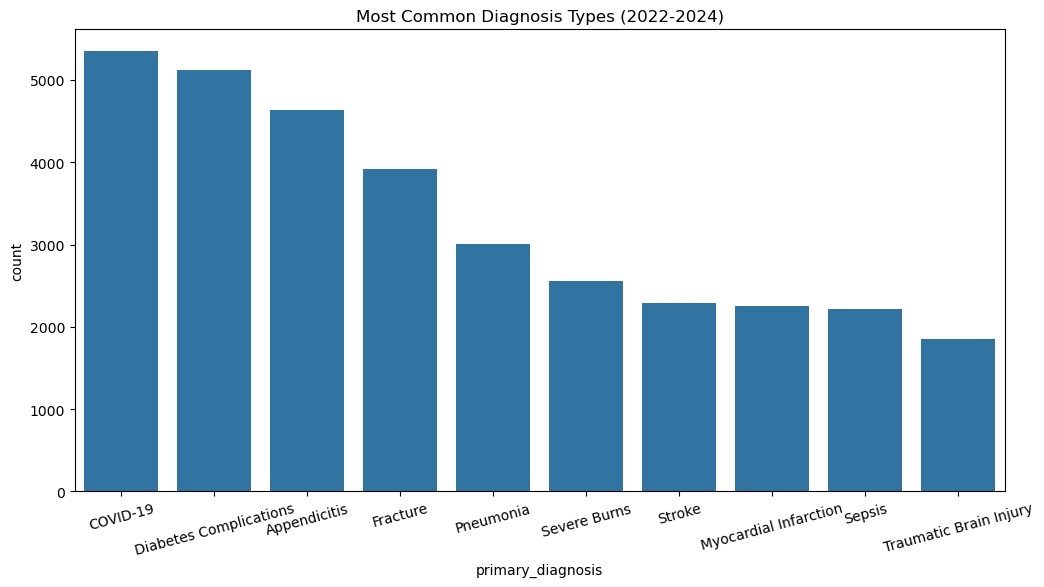

In [18]:
order = patient_df['primary_diagnosis'].value_counts().index

plt.figure(figsize=(12, 6))
sns.countplot(patient_df, x='primary_diagnosis', order=order)

plt.title('Most Common Diagnosis Types (2022-2024)')
plt.xticks(rotation=15)
plt.show()

### Consumable/Equipment Usage on Patients

In [20]:
patient_df['item_used'].value_counts()

item_used
Gloves                 7553
Syringe                3296
Cotton Rolls           2782
Surgical Mask          2678
Gown                   2340
IV Drip                2134
Infusion Pump          2134
Face Shield            2014
Antiseptic Solution    2002
Hospital Bed           1605
Bandages               1342
Blood Bags              910
X-Ray Machine           839
Ventilator              691
MRI Scanner             308
ECG Machine             205
Defibrillator           205
Wheelchair              176
Name: count, dtype: int64

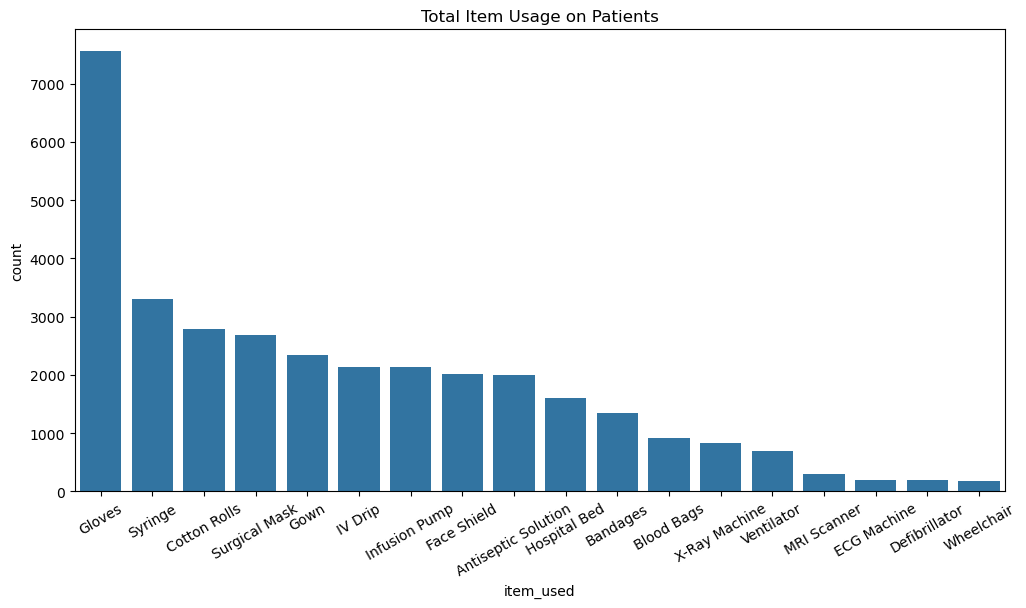

In [21]:
order = patient_df['item_used'].value_counts().index

plt.figure(figsize=(12, 6))
plt.title('Total Item Usage on Patients')
plt.xticks(rotation=30)
sns.countplot(patient_df, x='item_used', order = order)
plt.show()

<h2 style="padding: 0.5rem; background-color: #513d5c; color: white;">Bivariate Analysis</h2>

### Consumable - Mean Usage Per Day

In [24]:
consumable_avg_usage = inventory_df[inventory_df['category'] == 'Consumable'].groupby(inventory_df['title'])[['avg_usage_per_day']].mean()
consumable_avg_usage = consumable_avg_usage.reset_index().sort_values(by='avg_usage_per_day', ascending=False)
consumable_avg_usage

,title,avg_usage_per_day
8,Surgical Mask,1664.695238
9,Syringe,1144.154639
1,Bandages,899.039773
5,Gloves,581.613260
4,Face Shield,469.591623
0,Antiseptic Solution,304.046632
6,Gown,294.223301
3,Cotton Rolls,174.735000
7,IV Drip,127.494898
2,Blood Bags,86.514286


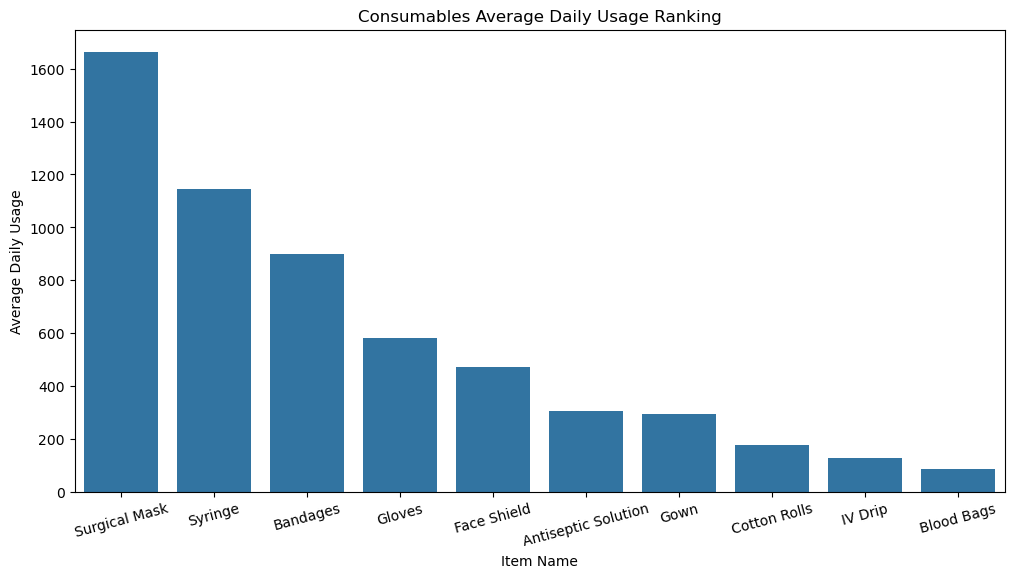

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(consumable_avg_usage, x='title', y='avg_usage_per_day')

plt.title('Consumables Average Daily Usage Ranking')
plt.xlabel('Item Name')
plt.ylabel('Average Daily Usage')
plt.xticks(rotation=15)
plt.show()

### Equipment - Mean Usage Per Day

In [27]:
equipment_avg_usage = inventory_df[inventory_df['category'] == 'Equipment'].groupby(inventory_df['title'])[['avg_usage_per_day']].mean()
equipment_avg_usage = equipment_avg_usage.reset_index().sort_values(by='avg_usage_per_day', ascending=False)
equipment_avg_usage

,title,avg_usage_per_day
3,Infusion Pump,10.179894
5,Ventilator,3.100457
6,Wheelchair,2.476923
2,Hospital Bed,1.616162
1,ECG Machine,1.561086
0,Defibrilator,0.490654
7,X-Ray-Machine,0.463918
4,MRI Scanner,0.446701


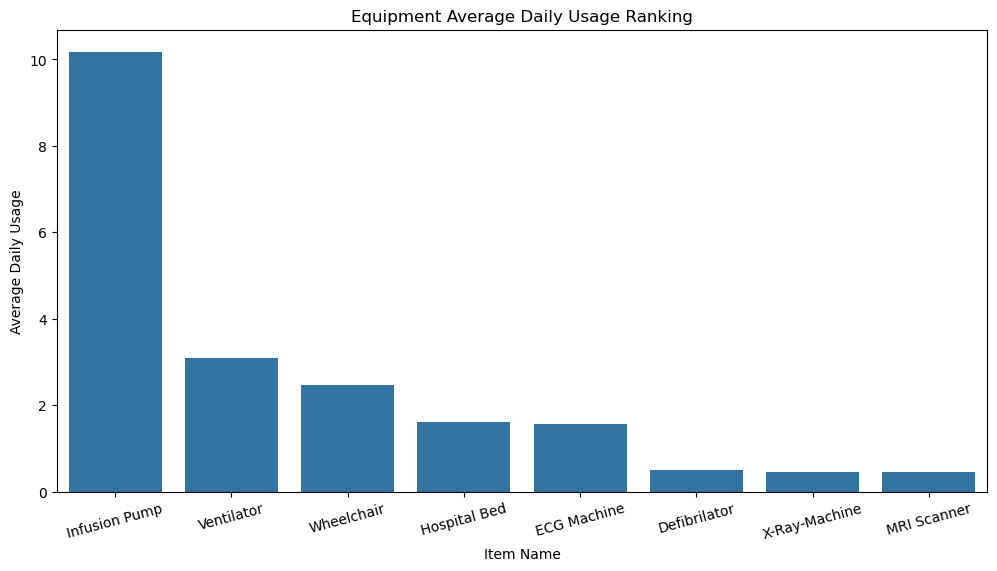

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(equipment_avg_usage, x='title', y='avg_usage_per_day')

plt.title('Equipment Average Daily Usage Ranking')
plt.xlabel('Item Name')
plt.ylabel('Average Daily Usage')
plt.xticks(rotation=15)
plt.show()

### Consumable vs Equipment - Mean Usage Per Day

In [30]:
item_top_usage = pd.concat([consumable_avg_usage.iloc[[0]], equipment_avg_usage.iloc[[0]]])
item_top_usage

,title,avg_usage_per_day
8,Surgical Mask,1664.695238
3,Infusion Pump,10.179894


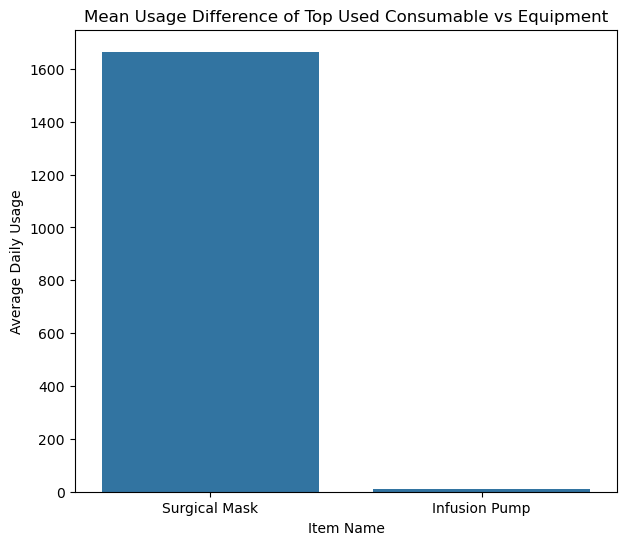

In [31]:
plt.figure(figsize=(7, 6))
plt.title('Mean Usage Difference of Top Used Consumable vs Equipment')
plt.xlabel('Item Name')
plt.ylabel('Average Daily Usage')
sns.barplot(item_top_usage, x='title', y='avg_usage_per_day')
plt.show()

<h1 style='font-size: 2.5rem; text-align: center;'>Feature Engineering</h1>

In [33]:
inventory_df

,_id,itemCode,title,description,category,abcCategory,minStockLevel,maxStockLevel,createdBy,status,createdAt,date,stock_status,unit_cost,current_stock,avg_usage_per_day,restock_lead_time,vendor_name,vendor_contact,expiration_date
0,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-14,Available,1571303,21,1,17,Mcdonald-Le Medical Supplies,+63 900 112 1712,NaN
1,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-15,Available,2824727,19,4,24,Ellis-Johnson Medical Supplies,+63 975 915 2123,NaN
2,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-15,Available,2626801,3,2,28,Ellis-Johnson Medical Supplies,+63 975 915 2123,NaN
3,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-27,Available,2347847,13,3,15,Sandoval and Sons Medical Supplies,+63 952 345 2479,NaN
4,67b5d1d3965831513a85d8be,100,Ventilator,A medical device that supports or takes over b...,Equipment,C,3,25,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2022-01-28,Available,1945377,10,2,26,Charles-Perry Medical Supplies,+63 914 128 7105,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-24,Available,53,1824,246,4,Sandoval and Sons Medical Supplies,+63 952 345 2479,1.892678e+12
3580,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-26,Available,141,1850,66,9,Taylor Inc Medical Supplies,+63 972 467 2353,1.892851e+12
3581,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-27,Available,67,529,233,4,Charles-Perry Medical Supplies,+63 914 128 7105,1.892938e+12
3582,67b5d1d3965831513a85d8cf,209,Cotton Rolls,"Soft, absorbent materials used in medical appl...",Consumable,C,300,2000,67b1fdb293bfc8e17f896b31,active,2025-02-19T12:42:59.839Z,2024-12-27,Available,148,460,192,9,Charles-Perry Medical Supplies,+63 914 128 7105,1.892938e+12


In [82]:
# Item Name, Date, Beginning Inventory, Ending Inventory, Monthly Usage
inventory_df1 = inventory_df.copy()
inventory_df1['date'] = pd.to_datetime(inventory_df1['date']) # Preprocessing: Datetime Conversion
inventory_df1['month'] = inventory_df1['date'].dt.to_period('M')
inventory_df1['year'] = inventory_df1['date'].dt.to_period('Y')

consumable_features = inventory_df1[inventory_df1['category'] == 'Consumable'].sort_values(['title', 'date']).groupby(['title', 'month']).agg(
        beginning_inventory = ('current_stock', 'first'),
        ending_inventory = ('current_stock', 'last'),
).reset_index()

consumable_features['category'] = 'Consumable'

equipment_features = inventory_df1[inventory_df1['category'] == 'Equipment'].sort_values(['title', 'date']).groupby(['title', 'year']).agg(
        beginning_inventory = ('current_stock', 'first'),
        ending_inventory = ('current_stock', 'last'),
).reset_index()

equipment_features['category'] = 'Equipment'

equipment_features = equipment_features.loc[equipment_features.index.repeat(12)].reset_index(drop=True)
equipment_features['month'] = pd.to_datetime(equipment_features['year'].astype(str) + '-' + np.tile(range(1, 13), len(equipment_features) // 12).astype(str)).dt.strftime('%Y-%m')
feature_df = pd.concat([consumable_features, equipment_features.drop(columns=['year'])])

# Annual Usage (For Equipment Turnover Rate)
annual_usage_df = inventory_df1.groupby(['title', 'year']).agg(annual_usage = ('avg_usage_per_day', 'sum')).reset_index()
feature_df['year'] = pd.to_datetime(feature_df['month'], format='%Y-%m')
feature_df['year'] = feature_df['year'].dt.to_period('Y')
feature_df = feature_df.merge(annual_usage_df, on=['title', 'year'], how='inner')

# Monthly Usage (For Consumable Turnover Rate) -> Shortcutting this by dividing annual usage by 12
feature_df['monthly_usage'] = feature_df['annual_usage'] / 12

'''

# To normalize in case the year is NOT YET COMPLETE (if year not complete = then the sum of the avg_usage is not really a year, but a few months only)
feature_df['annual_usage'] = feature_df.apply(lambda row: (row['annual_usage'] / row['months_available']) * 12, axis=1)

'''

# Unit Cost
cost_df = inventory_df.groupby('title')[['unit_cost']].mean().reset_index()
feature_df = feature_df.merge(cost_df, on='title', how='left')

# Annual Usage Value (AUG)
feature_df['annual_usage_value'] = feature_df['annual_usage'] * feature_df['unit_cost']

# Stock Turnover Rate
feature_df['stock_turnover_rate'] = np.where(feature_df['category'] == 'Consumable',
                                             feature_df['monthly_usage'] / ((feature_df['beginning_inventory'] + feature_df['ending_inventory']) / 2),
                                             feature_df['annual_usage'] / ((feature_df['beginning_inventory'] + feature_df['ending_inventory']) / 2),
                                            )

# Stock Variability
feature_df['stock_variability'] = inventory_df1.groupby('title')['current_stock'].transform(lambda x: x.std() / x.mean() if x.mean() != 0 else 0)

equipment_features
consumable_features
feature_df

,title,month,beginning_inventory,ending_inventory,category,year,annual_usage,monthly_usage,unit_cost,annual_usage_value,stock_turnover_rate,stock_variability
0,Antiseptic Solution,2022-01,2992,2464,Consumable,2022,17519,1459.916667,4.320000e+02,7.568208e+06,0.535160,0.484987
1,Antiseptic Solution,2022-02,2000,2000,Consumable,2022,17519,1459.916667,4.320000e+02,7.568208e+06,0.729958,0.484987
2,Antiseptic Solution,2022-03,2185,526,Consumable,2022,17519,1459.916667,4.320000e+02,7.568208e+06,1.077032,0.484987
3,Antiseptic Solution,2022-04,1543,1198,Consumable,2022,17519,1459.916667,4.320000e+02,7.568208e+06,1.065244,0.484987
4,Antiseptic Solution,2022-05,1224,1213,Consumable,2022,17519,1459.916667,4.320000e+02,7.568208e+06,1.198126,0.484987
...,...,...,...,...,...,...,...,...,...,...,...,...
642,X-Ray-Machine,2024-08,4,8,Equipment,2024,30,2.500000,3.757779e+06,1.127334e+08,5.000000,0.448397
643,X-Ray-Machine,2024-09,4,8,Equipment,2024,30,2.500000,3.757779e+06,1.127334e+08,5.000000,0.448397
644,X-Ray-Machine,2024-10,4,8,Equipment,2024,30,2.500000,3.757779e+06,1.127334e+08,5.000000,0.448397
645,X-Ray-Machine,2024-11,4,8,Equipment,2024,30,2.500000,3.757779e+06,1.127334e+08,5.000000,0.448397


In [35]:
# Styling: Rerranging columns only
feature_df = feature_df[[
    'title', 'year', 'month', 'category', 'unit_cost', 'beginning_inventory', 'ending_inventory', 'annual_usage_value',
    'monthly_usage', 'annual_usage', 'stock_turnover_rate', 'stock_variability'
]]

In [36]:
X_features = ['annual_usage_value', 'unit_cost', 'annual_usage', 'stock_turnover_rate', 'stock_variability']
X = feature_df[X_features]
X

,annual_usage_value,unit_cost,annual_usage,stock_turnover_rate,stock_variability
0,7.568208e+06,4.320000e+02,17519,0.535160,0.484987
1,7.568208e+06,4.320000e+02,17519,0.729958,0.484987
2,7.568208e+06,4.320000e+02,17519,1.077032,0.484987
3,7.568208e+06,4.320000e+02,17519,1.065244,0.484987
4,7.568208e+06,4.320000e+02,17519,1.198126,0.484987
...,...,...,...,...,...
642,1.127334e+08,3.757779e+06,30,5.000000,0.448397
643,1.127334e+08,3.757779e+06,30,5.000000,0.448397
644,1.127334e+08,3.757779e+06,30,5.000000,0.448397
645,1.127334e+08,3.757779e+06,30,5.000000,0.448397


<h1 style='font-size: 2.5rem; text-align: center;'>Clustering Model - ABC Analysis</h1>

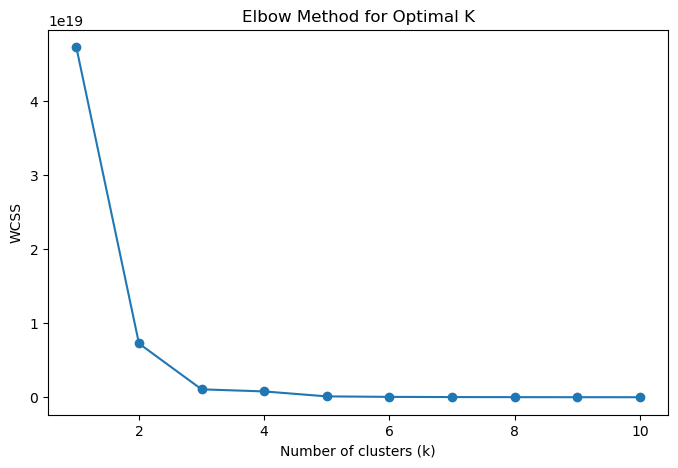

In [38]:
wcss = []  # Within-cluster sum of squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [72]:
# K-Means clustering with K=3 (for ABC analysis)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=1))
])

pipeline.fit(X)
clusters = pipeline.predict(X)
feature_df1 = feature_df.copy()
feature_df1['cluster'] = clusters

# Rename clusters to A, B, C based on AUV values
cluster_mapping = {
    feature_df1.groupby('cluster')['annual_usage_value'].mean().idxmax(): 'A',
    feature_df1.groupby('cluster')['annual_usage_value'].mean().idxmin(): 'C'
}
cluster_mapping = {k: cluster_mapping.get(k, 'B') for k in range(3)}

# Map cluster labels to A, B, C
feature_df1['ABC_category'] = feature_df1['cluster'].map(cluster_mapping)
feature_df1.drop('cluster', axis=1, inplace=True)
feature_df1

,title,year,month,category,unit_cost,beginning_inventory,ending_inventory,annual_usage_value,monthly_usage,annual_usage,stock_turnover_rate,stock_variability,ABC_category
0,Antiseptic Solution,2022,2022-01,Consumable,4.320000e+02,2992,2464,7.568208e+06,1459.916667,17519,0.535160,0.484987,C
1,Antiseptic Solution,2022,2022-02,Consumable,4.320000e+02,2000,2000,7.568208e+06,1459.916667,17519,0.729958,0.484987,C
2,Antiseptic Solution,2022,2022-03,Consumable,4.320000e+02,2185,526,7.568208e+06,1459.916667,17519,1.077032,0.484987,C
3,Antiseptic Solution,2022,2022-04,Consumable,4.320000e+02,1543,1198,7.568208e+06,1459.916667,17519,1.065244,0.484987,C
4,Antiseptic Solution,2022,2022-05,Consumable,4.320000e+02,1224,1213,7.568208e+06,1459.916667,17519,1.198126,0.484987,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,X-Ray-Machine,2024,2024-08,Equipment,3.757779e+06,4,8,1.127334e+08,2.500000,30,5.000000,0.448397,C
643,X-Ray-Machine,2024,2024-09,Equipment,3.757779e+06,4,8,1.127334e+08,2.500000,30,5.000000,0.448397,C
644,X-Ray-Machine,2024,2024-10,Equipment,3.757779e+06,4,8,1.127334e+08,2.500000,30,5.000000,0.448397,C
645,X-Ray-Machine,2024,2024-11,Equipment,3.757779e+06,4,8,1.127334e+08,2.500000,30,5.000000,0.448397,C


# Model Evaluation

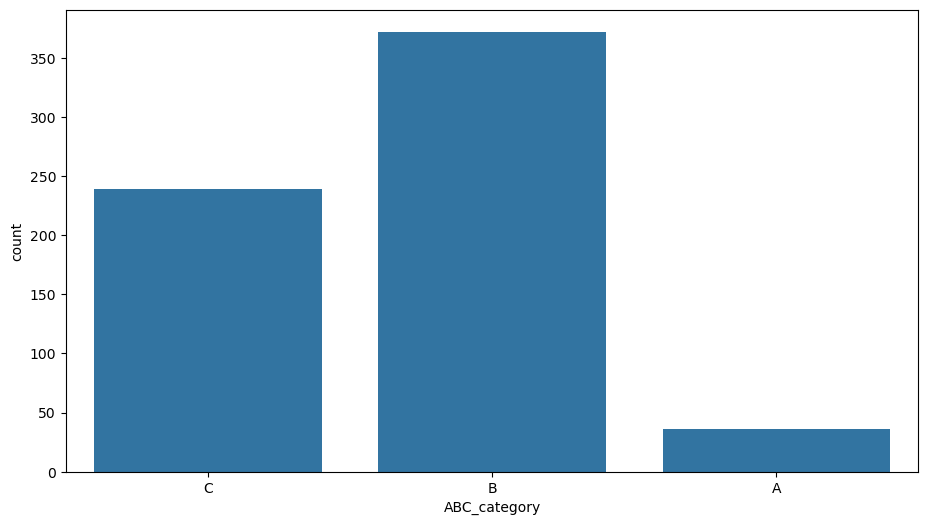

In [74]:
plt.figure(figsize=(11, 6))
sns.countplot(feature_df1, x='ABC_category')
plt.show()

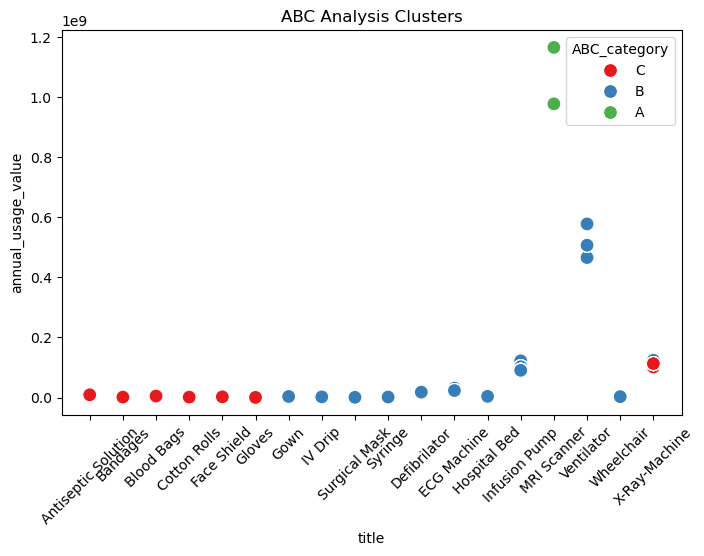

In [76]:
plt.figure(figsize=(8, 5))
sns.scatterplot(feature_df1, x='title', y='annual_usage_value', hue='ABC_category', palette='Set1', s=100)
plt.title('ABC Analysis Clusters')
plt.xticks(rotation=45)
plt.show()

# Model Export